# Importing the libraries and seting the paths

In [366]:
from utils import open_nea_table, download_nea_table
from mass_year import mass_vs_year_plot, planet_discovery_stat
import pandas as pd
import numpy as np
import os
import sys
from datetime import date
import math

from mr_utils import a_from_P, Teq_from_teff_v_plx_a, Teq_from_teff_v_plx_P, teq_hellper_function, a_from_P, MR_plot

from mr_ml_utils import score_dataset, optuna_RF_Reg, modified_learning_curve

If needed to update the NEA table then first run  "download_nea_table"

In [367]:
nea_full_table = open_nea_table()
nea_full_table.head(3)

c:\Users\adbva\OneDrive\codes_for_presentations\exoplanet_visualization\ExoPLots\utils.py:52: DtypeWarning: Columns (65,187) have mixed types. Specify dtype option on import or set low_memory=False.
  nea_full_table = pd.read_csv(table_directory)


,pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,gaia_id,default_flag,pl_refname,sy_refname,...,sy_jmagerr1,sy_jmagerr2,sy_jmagstr,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_kmag,sy_kmagerr1,sy_kmagerr2
0,OGLE-TR-10 b,b,OGLE-TR-10,NaN,NaN,TIC 130150682,Gaia DR2 4056443366649948160,1,<a refstr=TORRES_ET_AL__2008 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,NaN,NaN,13.692,13.314,0.121,-0.121,13.314&plusmn;0.121,12.856,NaN,NaN
1,BD-08 2823 c,c,BD-08 2823,NaN,HIP 49067,TIC 33355302,Gaia DR2 3770419611540574080,1,<a refstr=HEBRARD_ET_AL__2010 href=https://ui....,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.020,-0.020,7.96&plusmn;0.02,7.498,0.047,-0.047,7.498&plusmn;0.047,7.323,0.021,-0.021
2,HR 8799 c,c,HR 8799,HD 218396,HIP 114189,TIC 245368902,Gaia DR2 2832463659640297472,1,<a refstr=MAROIS_ET_AL__2008 href=https://ui.a...,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,...,0.027,-0.027,5.383&plusmn;0.027,5.280,0.018,-0.018,5.280&plusmn;0.018,5.240,0.018,-0.018


In [368]:
nea_full_table.columns.values

array(['pl_name', 'pl_letter', 'hostname', 'hd_name', 'hip_name',
       'tic_id', 'gaia_id', 'default_flag', 'pl_refname', 'sy_refname',
       'disc_pubdate', 'disc_year', 'discoverymethod', 'disc_locale',
       'disc_facility', 'disc_instrument', 'disc_telescope',
       'disc_refname', 'ra', 'rastr', 'dec', 'decstr', 'glon', 'glat',
       'elon', 'elat', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2',
       'pl_orbperlim', 'pl_orbperstr', 'pl_orblpererr1', 'pl_orblper',
       'pl_orblpererr2', 'pl_orblperlim', 'pl_orblperstr', 'pl_orbsmax',
       'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim',
       'pl_orbsmaxstr', 'pl_orbincl', 'pl_orbinclerr1', 'pl_orbinclerr2',
       'pl_orbincllim', 'pl_orbinclstr', 'pl_orbtper', 'pl_orbtpererr1',
       'pl_orbtpererr2', 'pl_orbtperlim', 'pl_orbtperstr', 'pl_orbeccen',
       'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim',
       'pl_orbeccenstr', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
       'pl_eqtlim', 'pl_eqtstr', 'pl_oc

# Selecting columns that are relevant for the ML analysis

In [369]:
relevant_columns = ['pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_orbsmax', 'pl_bmasse', 'pl_masseerr1', 'pl_masseerr2', 'pl_orbper',  'sy_vmag', 'sy_plx', 'st_teff', 'st_mass', 'st_met']
nea_relevant = nea_full_table[relevant_columns]


### Equilibrium temperature is important for the radius of hot planets. 

Selecting planets with Mass and Radius measurements for ML

In [370]:
nea_with_M_and_R = nea_relevant[(nea_relevant.pl_bmasse > 0) & (nea_relevant.pl_rade > 0) ].reset_index(drop=True) # reset index, drop old ones

print (f'There are {len(nea_with_M_and_R)} planets with mass and radius measurements')

nea_with_M_and_R.describe()

There are 1113 planets with mass and radius measurements


,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbsmax,pl_bmasse,pl_masseerr1,pl_masseerr2,pl_orbper,sy_vmag,sy_plx,st_teff,st_mass,st_met
count,1113.000000,1089.000000,1089.000000,878.000000,1113.000000,993.000000,993.000000,1.098000e+03,1110.000000,1085.000000,1032.000000,1100.000000,950.000000
mean,8.967707,0.663302,-0.575284,17.160037,420.861732,62.765269,-59.203874,3.790530e+05,12.274946,9.295143,5483.824806,1.003882,0.051183
std,6.083019,1.022459,0.798818,272.583363,963.110129,243.492003,229.348953,1.213509e+07,2.171725,17.976954,1361.837200,0.345527,0.197215
min,0.310000,0.006000,-6.730000,0.006000,0.070000,0.012000,-4767.450000,2.401040e-01,5.569110,-0.149186,575.000000,0.010000,-0.580000
25%,2.630000,0.119000,-0.695000,0.037958,10.100000,2.120000,-41.317900,3.003277e+00,11.012500,1.939290,5016.000000,0.820000,-0.070000
50%,10.447000,0.336000,-0.325000,0.053735,126.496340,14.937940,-14.302350,4.603155e+00,12.247000,3.516790,5620.000000,1.000000,0.060000
75%,13.787000,0.785000,-0.110000,0.100075,379.000000,43.541000,-2.000000,1.189179e+01,13.688000,7.961470,6009.000000,1.180000,0.190000
max,33.600000,10.536000,0.000000,7506.000000,9534.900000,4767.450000,-0.012000,4.020000e+08,20.154400,153.081000,27730.000000,2.780000,0.522000


There seem to be star(s) with negative parallaxes. They must be removed fromthe sample

In [371]:
nea_with_M_and_R = nea_with_M_and_R[nea_with_M_and_R.sy_plx > 0]

To calculate Teq, one needs Luminosity (us such, Teff, Vmag, and Plx) and semimajor axis (or orbital period ond Mstar)

In [372]:
#check how many nan values have in each column
nea_with_M_and_R.isna().sum()

pl_rade           0
pl_radeerr1      22
pl_radeerr2      22
pl_orbsmax      234
pl_bmasse         0
pl_masseerr1    118
pl_masseerr2    118
pl_orbper        13
sy_vmag           0
sy_plx            0
st_teff          78
st_mass          11
st_met          148
dtype: int64

There are 235 missing entries for semimajor axis. This parameter can be estimated from the stellar mass and orbital period.

Next, all the rows containing nan values will be removed, except if the nan is in the "pl_orbsmax" column

In [373]:
nea_with_M_and_R_cleaned = nea_with_M_and_R.dropna(subset=nea_with_M_and_R.columns.drop('pl_orbsmax'))
# Check results
nea_with_M_and_R_cleaned.isna().sum()


pl_rade           0
pl_radeerr1       0
pl_radeerr2       0
pl_orbsmax      160
pl_bmasse         0
pl_masseerr1      0
pl_masseerr2      0
pl_orbper         0
sy_vmag           0
sy_plx            0
st_teff           0
st_mass           0
st_met            0
dtype: int64

In [374]:
print (f'There are {len(nea_with_M_and_R_cleaned)} planets for the ML analysis')
nea_with_M_and_R_cleaned.head(3)

There are 828 planets for the ML analysis


,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbsmax,pl_bmasse,pl_masseerr1,pl_masseerr2,pl_orbper,sy_vmag,sy_plx,st_teff,st_mass,st_met
4,16.870,0.560,-0.504,0.0535,271.74465,22.88376,-21.93027,3.899052,12.006,1.73126,5941.0,1.34,0.164
5,21.633,5.044,-5.044,NaN,352.79130,171.62820,-171.62820,2.175180,11.965,1.29679,6100.0,1.87,-0.350
6,12.722,0.538,-0.538,0.0466,180.84527,7.31009,-6.99226,3.652815,13.146,3.30091,5519.0,1.01,0.294


Calculating semimajor axis from Period and stellar mass, for the missing "a" entries

In [375]:
for i in range(len(nea_with_M_and_R_cleaned)):
    if np.isnan(nea_with_M_and_R_cleaned.iloc[i]['pl_orbsmax']):
        nea_with_M_and_R_cleaned.iloc[i]['pl_orbsmax'] = a_from_P(nea_with_M_and_R_cleaned.iloc[i]['st_mass'], nea_with_M_and_R_cleaned.iloc[i]['pl_orbper'])


Calculating Teq from "a" or "P" 

Use teq_hellper_function function to determine Teq from "a" or "P" depending on their availability. Priority is given to "a"

In [376]:
# Add new columns: Teq
nea_with_M_and_R_cleaned['Teq'] = 0

nea_with_M_and_R_cleaned = nea_with_M_and_R_cleaned.apply(lambda x: teq_hellper_function(x, 'pl_orbsmax', 'pl_orbper', 'st_teff', 'sy_vmag', 'sy_plx', 'st_mass', 'Teq'), axis = 1)

C:\Users\adbva\AppData\Local\Temp\ipykernel_18348\293283582.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nea_with_M_and_R_cleaned['Teq'] = 0


In [377]:
# very 'cool' planets
print (display(nea_with_M_and_R_cleaned[nea_with_M_and_R_cleaned.Teq < 100]))

#Some of the parameters used to calculate the Teq must be wrong. These objects should be removed

nea_with_M_and_R_cleaned = nea_with_M_and_R_cleaned[nea_with_M_and_R_cleaned.Teq > 10]

,pl_rade,pl_radeerr1,pl_radeerr2,pl_orbsmax,pl_bmasse,pl_masseerr1,pl_masseerr2,pl_orbper,sy_vmag,sy_plx,st_teff,st_mass,st_met,Teq
526,21.196,0.684,-0.594,0.03462,915.35040,266.97720,-266.97720,1.481124e+00,7.55000,4.86254,10170.0,2.52,-0.03,0.0
690,20.288,1.009,-1.009,0.05580,527.59780,38.13960,-38.13960,3.344829e+00,9.94600,2.31187,9360.0,2.07,0.21,0.0
696,18.147,0.235,-0.235,0.05053,632.47853,50.85255,-44.49598,2.724033e+00,6.59776,9.99903,8000.0,2.03,0.29,0.0
1058,12.442,0.336,-0.336,7506.00000,2002.31896,476.74261,-603.87397,4.020000e+08,11.29800,91.82910,3406.0,0.37,0.00,1.0


None


### Selecting plaents with relatively high precision in Mass and Radius

In [378]:
# calculating the mean errors of M and R
nea_with_M_and_R_cleaned['pl_rade_err'] = (nea_with_M_and_R_cleaned['pl_radeerr1'] - nea_with_M_and_R_cleaned['pl_radeerr2'])/2
nea_with_M_and_R_cleaned['pl_bmasse_err'] = (nea_with_M_and_R_cleaned['pl_masseerr1'] - nea_with_M_and_R_cleaned['pl_masseerr2'])/2

In [379]:
M_threshold = 0.5
R_threshold = 0.5
precise_criteria = (nea_with_M_and_R_cleaned['pl_rade_err']/nea_with_M_and_R_cleaned['pl_rade'] < R_threshold) & (nea_with_M_and_R_cleaned['pl_bmasse_err']/nea_with_M_and_R_cleaned['pl_bmasse'] < M_threshold)
nea_with_M_and_R_cleaned_accurate = nea_with_M_and_R_cleaned[precise_criteria]

print (f'There are {len(nea_with_M_and_R_cleaned_accurate)} precisely characterized planets in terms of Mass and Radius')

There are 787 precisely characterized planets in terms of Mass and Radius


In [380]:
# Final table with Mass, Radius, and Teq
nea_MR_final_table = nea_with_M_and_R_cleaned_accurate[['pl_rade', 'pl_bmasse', 'Teq', 'st_teff', 'pl_orbsmax', 'st_met']]
nea_MR_final_table.head(2)

,pl_rade,pl_bmasse,Teq,st_teff,pl_orbsmax,st_met
4,16.870,271.74465,1744.0,5941.0,0.053500,0.164
5,21.633,352.79130,5466.0,6100.0,0.007337,-0.350


# Starting the Machine Learning part

Since the accuracy of Mass estimation is not critical, I'll make things simple (but still keeping the state-of-the-art): 

Use XGBoost regressor and tune HyperParameters with "optuna" (sometimes better than grid_search see e.g. [this](https://medium.com/mlearning-ai/hyper-parameter-tuning-through-grid-search-and-optuna-2bd89a2ece06)

In [381]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Displaying the data

In [382]:
nea_MR_final_table.describe()

,pl_rade,pl_bmasse,Teq,st_teff,pl_orbsmax,st_met
count,787.000000,787.000000,787.000000,787.000000,787.000000,787.000000
mean,9.671449,343.183608,1489.659466,5479.273952,0.084388,0.063590
std,5.668087,627.189034,977.232667,822.983351,0.173857,0.193171
min,0.640000,0.070000,144.000000,2960.000000,0.001257,-0.580000
25%,3.000000,12.600000,833.000000,5147.500000,0.028015,-0.044500
50%,11.400000,160.497000,1305.000000,5638.000000,0.046600,0.080000
75%,14.005500,378.535530,1709.500000,6020.500000,0.074650,0.200000
max,22.754000,6388.100000,6960.000000,7930.000000,2.720500,0.522000


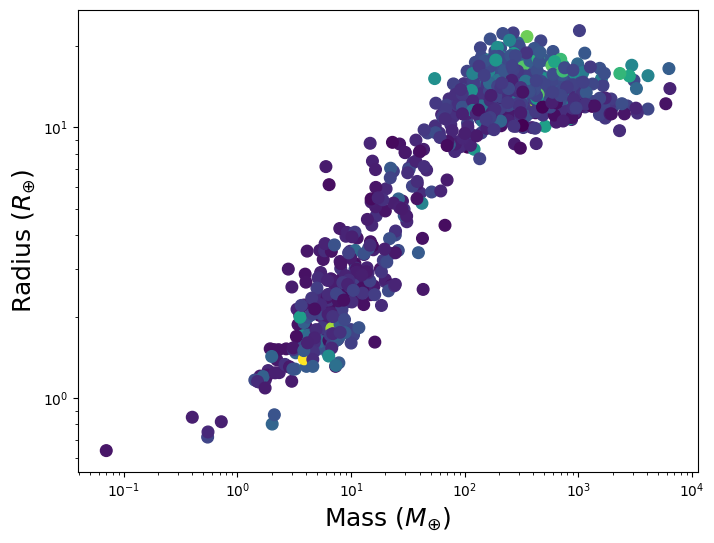

In [383]:
fig = plt.figure(1, figsize = (8,6))
ax = plt.subplot(1,1,1)
MR_plot(ax, nea_MR_final_table.pl_bmasse, nea_MR_final_table.pl_rade, color = nea_MR_final_table['Teq'])

C:\Users\adbva\AppData\Local\Temp\ipykernel_18348\2374921187.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 6, i+1)


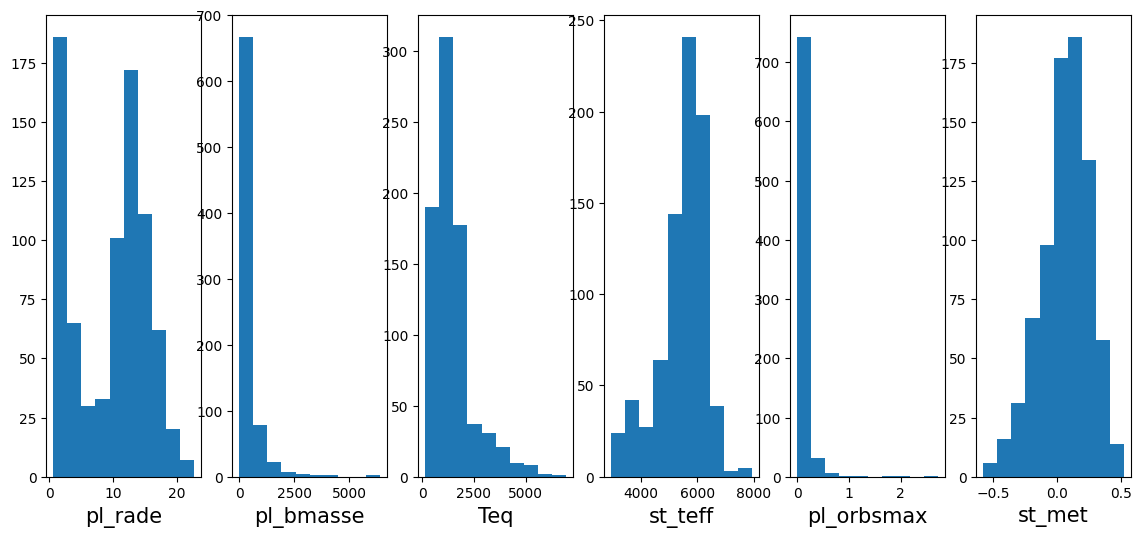

In [384]:
fig = plt.figure(2, figsize = (14,6))
ax = plt.gca()

for i, col  in enumerate(nea_MR_final_table.columns):
    ax = plt.subplot(1, 6, i+1)
    ax.hist((nea_MR_final_table[col]))
    ax.set_xlabel(col, fontsize = 15)

In [385]:
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from  xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

Sizes of the samples:
Train = 668, Test = 119


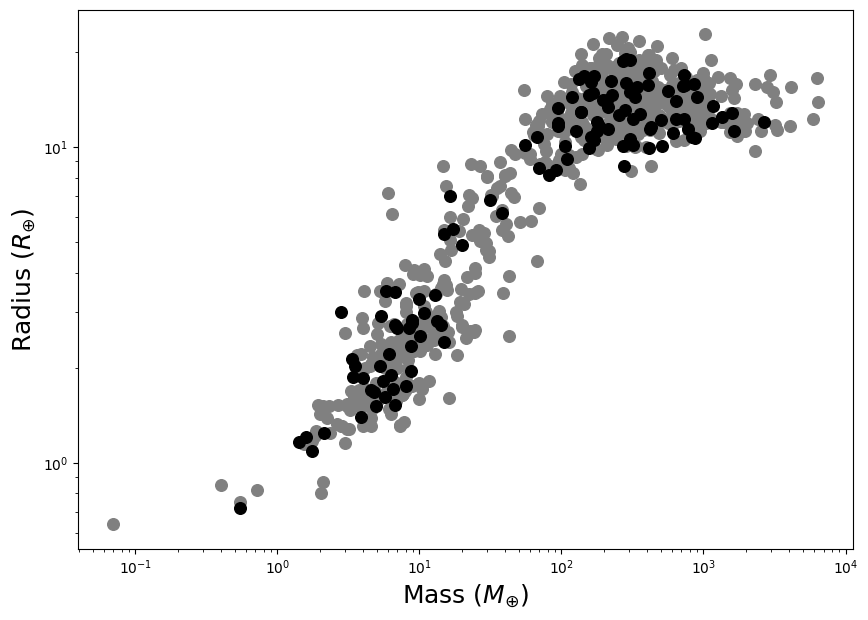

In [386]:
y = nea_MR_final_table['pl_bmasse']
X = nea_MR_final_table.drop(columns = ['pl_bmasse'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

print (f'Sizes of the samples:\nTrain = {len(X_train)}, Test = {len(X_test)}')

fig = plt.figure(figsize = (10,7))
ax = plt.subplot(1,1, 1)
MR_plot(ax, y_train, X_train.pl_rade, color = 'gray', xscale = 'log', yscale = 'log')
MR_plot(ax, y_test, X_test.pl_rade, color = 'black', xscale = 'log', yscale = 'log')

In [387]:
RFR_base_model = RandomForestRegressor(random_state =0)
MAE_base = score_dataset(X_train, y_train, RFR_base_model)

print (f'The base MAE score for the full data is {MAE_base:.0f}')

The base MAE score for the full data is 259


In [388]:
RFR_best_params = optuna_RF_Reg(X_train, y_train, n_trials = 50, display = False)

[I 2023-07-11 23:14:38,612] A new study created in memory with name: no-name-8a049b34-6d03-43be-9ea2-599a970b6722
[I 2023-07-11 23:14:40,737] Trial 0 finished with value: 248.09571373931894 and parameters: {'n_estimators': 160, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 4}. Best is trial 0 with value: 248.09571373931894.
[I 2023-07-11 23:14:41,727] Trial 1 finished with value: 249.5230894613177 and parameters: {'n_estimators': 120, 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 2}. Best is trial 0 with value: 248.09571373931894.
[I 2023-07-11 23:14:41,983] Trial 2 finished with value: 245.70144276877426 and parameters: {'n_estimators': 20, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 4}. Best is trial 2 with value: 245.70144276877426.
[I 2023-07-11 23:14:42,217] Trial 3 finished with value: 288.7729814313956 and parameters: {'n_estimators': 40, 'max_depth': 2, 'min_samples_split': 5,


The best hyperparameters for RF Regressor {'n_estimators': 140, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 4}


In [389]:
y_train_predict = RandomForestRegressor(**RFR_best_params).fit(X_train, y_train).predict(X_train)
y_test_predict = RandomForestRegressor(**RFR_best_params).fit(X_train, y_train).predict(X_test)
print (f'\nAME of the BEST RF Regressor: Training data {(mean_absolute_error(y_train, y_train_predict))}')
print (f'\nAME of the BEST RF Regressor: Test data {(mean_absolute_error(y_test, y_test_predict))}')


AME of the BEST RF Regressor: Training data 202.2294029755155

AME of the BEST RF Regressor: Test data 190.2288590063003


In [390]:
import joblib

final_model_full_data = RandomForestRegressor(**RFR_best_params).fit(X, y)
final_model_train_data = RandomForestRegressor(**RFR_best_params).fit(X_train, y_train)

# Save the model and its parameters
joblib.dump(final_model_full_data, 'RF_model_full_data.pkl')
joblib.dump(final_model_train_data, 'RF_model_train_data.pkl')

['RF_model_train_data.pkl']


0
For a training size of 66, MAE(train) = 279.910 and MAE(test) = 242.156
1
For a training size of 215, MAE(train) = 222.819 and MAE(test) = 204.726
2
For a training size of 364, MAE(train) = 220.964 and MAE(test) = 197.842
3
For a training size of 512, MAE(train) = 202.453 and MAE(test) = 185.597
4
For a training size of 661, MAE(train) = 201.486 and MAE(test) = 185.244


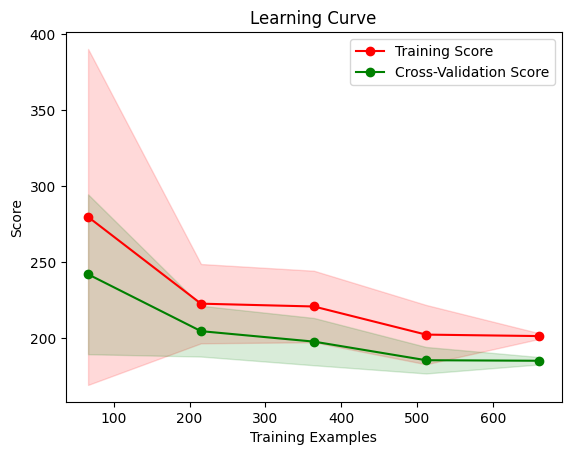

In [391]:
# Load the model and its parameters
best_RF = joblib.load('RF_model_train_data.pkl')
results = modified_learning_curve(X_train, y_train, X_test, y_test, best_RF, 5)

In [392]:
best_RF = RandomForestRegressor(**RFR_best_params).fit(X_train, y_train)
y_pred = best_RF.predict(X_test)

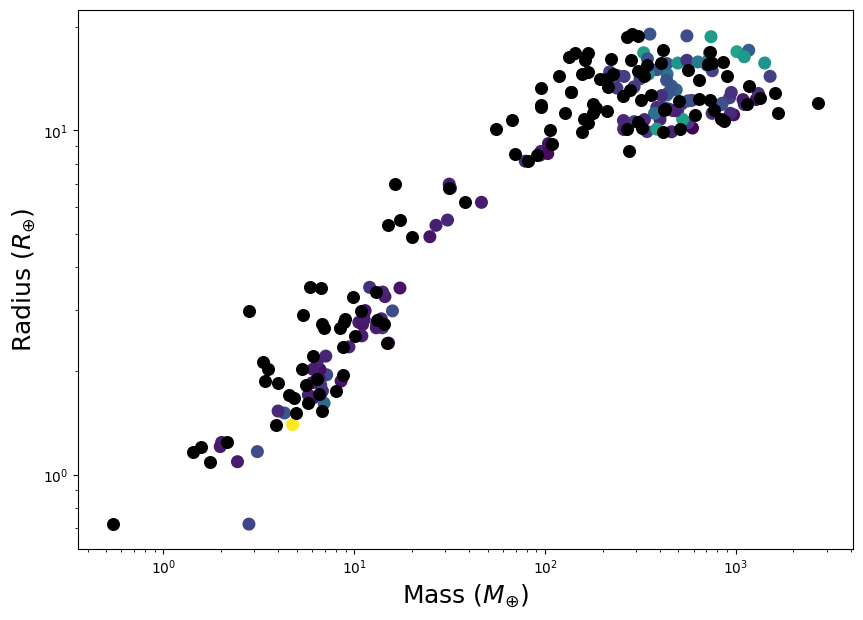

In [393]:
fig = plt.figure(figsize = (10,7))
ax = plt.subplot(1,1, 1)
MR_plot(ax, y_pred, X_test.pl_rade, color = X_test.Teq, xscale = 'log', yscale = 'log')
MR_plot(ax, y_test, X_test.pl_rade, color = 'black', xscale = 'log', yscale = 'log')


-0.8454574553999261 -0.46272658392196553


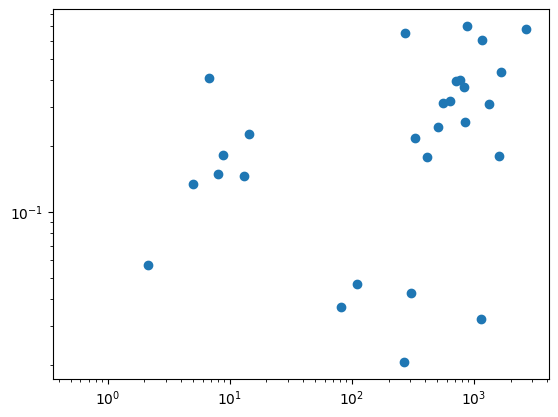

In [394]:
plt.scatter(y_test, (y_test - y_pred)/y_test)
plt.yscale('log')
plt.xscale('log')
print (np.mean((y_test - y_pred)/y_test), np.median((y_test - y_pred)/y_test))

In [395]:
nea_MR_final_table = nea_with_M_and_R_cleaned_accurate[['pl_rade', 'pl_bmasse', 'Teq', 'st_teff', 'pl_orbsmax']]

nea_MR_final_table['pl_rade'] = np.log10(nea_MR_final_table['pl_rade'])
nea_MR_final_table['pl_bmasse'] = np.log10(nea_MR_final_table['pl_bmasse'])

C:\Users\adbva\AppData\Local\Temp\ipykernel_18348\1353724171.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nea_MR_final_table['pl_rade'] = np.log10(nea_MR_final_table['pl_rade'])
C:\Users\adbva\AppData\Local\Temp\ipykernel_18348\1353724171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nea_MR_final_table['pl_bmasse'] = np.log10(nea_MR_final_table['pl_bmasse'])
